# Speech-to-Speech Abstractive Summarisation

In this project we are Using How2 Dataset [link](https://srvk.github.io/how2-dataset/) which is a collection of instructional YouTube videos with English subtitles IDs and human-made summaries. This project is concerned with the transformation of audio to audio and as such, the audio has been ripped from the videos.

* Task 1a) Construct databases of video transcriptions and human made descriptions
* Task 1b) Download audios of 400 videos
* Task 1c) Align transcriptions to the audios 
* Task 1d) Sequence Labelling and Feature Significance

### Task 1a) Construct databases of video transcriptions and human made descriptions

In [9]:
# Load the test dataset into a pandas data frame
import pandas as pd
# Load the descriptions into a pandas data frame
desctable = pd.read_csv('speech_data/text/sum_cv/desc.tok.txt', header=None, skipinitialspace=True, names=["a"])
desctable.head()
filename = 'speech_data/text/sum_cv/tran.tok.txt'
with open(filename, 'r') as f:
    data = f.read().replace('\n','%%%')
    
# Load the transcriptions into into a pandas data frame 
trantable = pd.read_csv(pd.compat.StringIO(data), sep="%%%", header=None)
trantable = trantable.T
trantable.drop(trantable.tail(1).index,inplace=True)
trantable.columns=['a']

/Users/dayangraham/opt/anaconda3/envs/FYPenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# Split id and description
desctable['id'] = desctable.apply(lambda row: str(row.a).split(" ")[0], axis = 1) 
desctable['desc'] = desctable.apply(lambda row: ' '.join(str(row.a).split(" ")[1:]), axis = 1) 
desctable.drop('a',1,inplace=True)
# Split id and transcription
trantable['id'] = trantable.apply(lambda row: row.a.split(" ")[0], axis = 1) 
trantable['tran'] = trantable.apply(lambda row: ' '.join(row.a.split(" ")[1:]), axis = 1) 
trantable.drop('a',1,inplace=True)

# Join tables on ID to create a single table 
conctable = pd.merge(desctable,trantable,on="id")
conctable.head()

,id,desc,tran
0,-xd1aAlPXqs,learn the sivananda yoga single right leg rais...,after you 've done at least six to twelve roun...
1,KtMjOT6fDrw,learn how to apply hanger hooks for your woodc...,"on behalf of expert village , my name is husai..."
2,ehbFyYlcEhc,learn about how hand washing can help prevent ...,hi ! this is david jackel on behalf of expert ...
3,lcw8f2od6z8,how to julienne cucumbers to make kimchi for k...,the other way we can do cucumbers which is als...
4,G-VRHmkiqtc,in order to put photographic emulsion on water...,my name is anthony maddaloni and i 'm going to...


### Task 1b) Download audios of 400 videos

In [7]:
# # Install dependencies to get audio from YouTube
# !pip -q install wget youtube-dl wget 

In [ ]:
# # Loop over the 400 YouTube videos
# # Save each video's audio as 8000Hz wav
# for YOUTUBE_ID in shortlist:
#     !youtube-dl --extract-audio --audio-format wav --quiet --output "{YOUTUBE_ID}_FULL.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
#     !ffmpeg -loglevel panic -y -i {YOUTUBE_ID}_FULL.wav -acodec pcm_s16le -ac 1 -ar 8000 {YOUTUBE_ID}.wav
#     !rm {YOUTUBE_ID}_FULL.wav

In [ ]:
# # Take the first 400 YouTube video IDs
# youtube_ids = conctable['id'].tolist()
# shortlist = youtube_ids[:400]

In [11]:
exploretable = conctable

In [12]:
exploretable.loc[:,'intersection'] = exploretable.apply(lambda row: [value for value in row.desc.split(" ") if value in row.tran.split(" ")] , axis=1)
exploretable.loc[:,'descnottran'] = exploretable.apply(lambda row: [value for value in row.desc.split(" ") if value not in row.tran.split(" ")] , axis=1)

In [13]:
# Calculate ROUGE statistics for the video descriptions and the video transcriptions
from rouge import Rouge 
rouge = Rouge()
exploretable['rouge1-f'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-1']['f'], axis=1)
exploretable['rouge1-r'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-1']['r'], axis=1)
exploretable['rouge1-p'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-1']['p'], axis=1)
exploretable['rouge2-f'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-2']['f'], axis=1)
exploretable['rouge2-r'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-2']['r'], axis=1)
exploretable['rouge2-p'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-2']['p'], axis=1)
exploretable['rougel-f'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-l']['f'], axis=1)
exploretable['rougel-r'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-l']['r'], axis=1)
exploretable['rougel-p'] = exploretable.apply(lambda row:  rouge.get_scores(row.desc, row.tran)[0]['rouge-l']['p'], axis=1)

In [17]:
import os
from os.path import isfile, join
exploretable['downloaded'] = exploretable.apply(lambda row: os.path.isfile(f'./speech_audios/{row.id}.wav'), axis=1)

In [63]:
from datetime import datetime
dt_string = datetime.now().strftime("%d%m%Y")
exploretable.to_pickle(f'./exploretable{dt_string}.pkl')

### Task 1c) Align transcriptions to the audios

In [13]:
# Alignment of transcription to audio

# Define imports for Kaldi Alignment
from kaldi.alignment import NnetAligner
from kaldi.fstext import SymbolTable
from kaldi.lat.align import WordBoundaryInfoNewOpts, WordBoundaryInfo
from kaldi.nnet3 import NnetSimpleComputationOptions
from kaldi.util.table import SequentialMatrixReader
import string

In [150]:
def aspire_alignment():
    # Construct aligner
    decodable_opts = NnetSimpleComputationOptions()
    decodable_opts.acoustic_scale = 1.0
    decodable_opts.frames_per_chunk = 150
    aligner = NnetAligner.from_files(
        "exp/tdnn_7b_chain_online/final.mdl",
        "exp/tdnn_7b_chain_online/tree",
        "data/lang/L.fst",
        "data/lang/words.txt",
        "data/lang/phones/disambig.int",
        decodable_opts=decodable_opts)
    phones = SymbolTable.read_text("data/lang/phones.txt")
    wb_info = WordBoundaryInfo.from_file(WordBoundaryInfoNewOpts(),
                                         "data/lang/phones/word_boundary.int")

    # Define feature pipelines as Kaldi rspecifiers
    feats_rspec = (
        "ark:compute-mfcc-feats --config=conf/mfcc_hires.conf scp:data/test/wav.scp ark:- |"
    )
    ivectors_rspec = (
        "ark:compute-mfcc-feats --config=conf/mfcc_hires.conf scp:data/test/wav.scp ark:- |"
        "ivector-extract-online2 --config=conf/ivector_extractor.conf ark:data/test/spk2utt ark:- ark:- |"
    )

    alignments=[]
    # Align wav files
    with SequentialMatrixReader(feats_rspec) as f, \
         SequentialMatrixReader(ivectors_rspec) as i, \
         open("data/test/text","r") as t:
        for (fkey, feats), (ikey, ivectors), line in zip(f, i, t):
            tkey, text = line.strip().split(None, 1)
            text = text.translate(str.maketrans('', '', string.punctuation))
            assert(fkey == ikey == tkey)
            out = aligner.align((feats, ivectors), text)
            word_alignment = aligner.to_word_alignment(out["best_path"], wb_info)
#             print(tkey)
            with open(f'alignments/{tkey}.txt', 'w') as f:
                print(f"{word_alignment}", file=f)
#             alignments.append(word_alignment)
#             print(f"The Input Text: {text}")
#             print(f"The word alignment: {word_alignment}")
#     return alignments

### File structure within the /data folder is as follows :
-    /lang
-    /test
-        spk2utt - maps speakers to utterances? just repeat double unique id eg utt1 utt1
-        text - transcription for each utterance on each line 
-        utt1.wav
-        wav.scp

In [173]:
def generateAlignmentDeps(table):
    downloadtable = table.query('downloaded==True')
    tranlist = downloadtable['tran'].tolist()
    idlist = downloadtable['id'].tolist()
#generate spk2utt 
    with open("data/test/spk2utt", 'w') as f:
        for id in idlist:
            print(f"{id} {id}", file=f)
#generate text 
    with open("data/test/text", 'w') as f:
        for index, id in enumerate(idlist):
            tran = tranlist[index]
            print(f"{id} {tran}", file=f)
#generate wav.scp 
    with open("data/test/wav.scp", 'w') as f:
        for id in idlist:
            print(f"{id} speech_audios/{id}.wav", file=f)

generateAlignmentDeps(exploretable)

In [ ]:
# Ensure that you have run alignment_dependencies/path.sh in order to add Kaldi to the PATH

#HACKY FIX IMPLEMENTED 
#IN PyKaldi API, if word not found in symbol table (out of vocabulary) it is set to <unk> or index 16. 
# The effect of this upon results needs to be discussed
aspire_alignment();

### Task 1d) Sequence Labelling and Feature Significance

WAV file -> N-dimension feature vector
*    The WAV file is analysed in 100ms frames
*    For each 100ms frame a feature vector is generated containing the following information:
*    The min, max, median, mean and range of the pitch (based on 10ms subframes)
*    The min, max, median, mean and range of the energy (based on 10ms subframes)
*    Mel Cepstral Coefficients + 1st and 2nd derivatives

Frame * 100
Utterance Length stays the same
Alignment * 10


In [ ]:
from pydub import AudioSegment
from pydub.playback import play
def playback(play_original, word_spacing,buffer,ID):
    originalutterance = AudioSegment.from_wav(f'./speech_audios/{ID}.wav')
    silence = AudioSegment.silent(duration=word_spacing)
    if play_original:
        play(originalutterance)
    for word in word_alignment:
        if (word[0] != '<eps>'):
            start_time = word[1]*10-buffer
            end_time = start_time + word[2]*10+buffer
            print(word[0])
            snippet = originalutterance[start_time:end_time]
            padded_snippet = silence.append(snippet.append(silence, crossfade=word_spacing/2),crossfade=word_spacing/2)
            play(padded_snippet)

In [18]:
from os import listdir
from os.path import isfile, join
matfiles = [file for file in listdir("./acoustic_feats_170520/") if file.endswith('.mat')]

In [92]:
from sklearn import preprocessing
from pydub import AudioSegment
import scipy.io
import numpy as np
from stop_words import get_stop_words
stop_words = get_stop_words('en')

FEATUREPATH = "./acoustic_feats_170520/"
AUDIOPATH = "./speech_audios/"
ALIGNMENTPATH = "alignments/"

positives=[]
negatives=[]
for matfile in matfiles[:20]:
    try:
        feats = scipy.io.loadmat(FEATUREPATH+matfile)['ret']
        chosenid = matfile.replace(".mat","")
        audiofile = AudioSegment.from_wav(f'{AUDIOPATH}{chosenid}.wav')
        alignment =  eval(open(f'{ALIGNMENTPATH}{chosenid}.txt', "r").read())

        row = exploretable.query(f'id=="{chosenid}"')
        description = set(row['desc'].values[0].split(" "))
        transcription = set(row['tran'].values[0].split(" "))
        intersection = description&transcription

        importantwords = list(filter(lambda x: x[0] in intersection and x[0] not in stop_words, alignment))

        impidx = []
        for imp in importantwords:
            start = (imp[1]- (imp[1]%10))//10 
            gap =  round((imp[2]/10- (imp[2]%1)))
            end = start + gap
            idx = list(range(start,end))
            impidx.extend(idx)
        positiveframes=feats[impidx]
        negativeframes=np.delete(feats, impidx,axis=0)
        positives.extend(positiveframes)
        negatives.extend(negativeframes)
    except:
        pass

positives =  np.asarray(positives)
negatives =  np.asarray(negatives)
data = np.concatenate((positives, negatives))
data = preprocessing.scale(data)
labels = [1]*len(positives) + [0]*len(negatives)

In [133]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=123)
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support


#Create a svm Classifier
clf = svm.SVC(class_weight={1: 10}) 

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
clf.score(X_test,y_test)

Y_pred = clf.predict(X_test)
print(f"The length of y_test is {len(y_test)}")
print(f"The 1s in  Y_pred are {np.unique(Y_pred, return_counts=True)}")
print(f"The 1s in  y_test are {np.unique(y_test, return_counts=True)}")
print(precision_recall_fscore_support(y_test, Y_pred, average='macro'))

The length of y_test is 4796
The 1s in  Y_pred are (array([0, 1]), array([4738,   58]))
The 1s in  y_test are (array([0, 1]), array([4669,  127]))
(0.6349434506047946, 0.5625384720463166, 0.5838659537607129, None)


In [107]:
from sklearn.linear_model import LogisticRegression
logi = LogisticRegression(random_state=0,class_weight={1: 16}).fit(X_train, y_train)
res = logi.predict(X_test)
print(f"The length of y_test is {len(y_test)}")
print(f"The 1s in  Y_pred are {np.unique(res, return_counts=True)}")
print(f"The 1s in  y_test are {np.unique(y_test, return_counts=True)}")
print(precision_recall_fscore_support(y_test, res, average='macro'))

The length of y_test is 4796
The 1s in  Y_pred are (array([0, 1]), array([4509,  287]))
The 1s in  y_test are (array([0, 1]), array([4669,  127]))
(0.5174188981695919, 0.538015019486882, 0.5203611240068932, None)


In [109]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
rf_pred=clf.predict(X_test)
print(f"The length of y_test is {len(y_test)}")
print(f"The 1s in  Y_pred are {np.unique(rf_pred, return_counts=True)}")
print(f"The 1s in  y_test are {np.unique(y_test, return_counts=True)}")
print(precision_recall_fscore_support(y_test, rf_pred, average='macro'))

The length of y_test is 4796
The 1s in  Y_pred are (array([0, 1]), array([4731,   65]))
The 1s in  y_test are (array([0, 1]), array([4669,  127]))
(0.6035477944165325, 0.5537006524859055, 0.5695079787234043, None)


In [111]:
feature_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False)

In [117]:
feature_imp

10    0.030916
16    0.029299
12    0.028069
13    0.027207
25    0.025781
41    0.025079
34    0.025000
18    0.024783
32    0.024633
9     0.024064
33    0.023920
8     0.023485
6     0.023427
5     0.023427
40    0.023235
36    0.022746
31    0.022599
42    0.022571
15    0.022464
11    0.022453
30    0.022394
27    0.022161
19    0.021830
21    0.021767
29    0.021633
43    0.021362
44    0.021317
24    0.021177
38    0.021062
35    0.020888
20    0.020804
37    0.020755
2     0.020683
7     0.020278
23    0.020206
4     0.020096
14    0.020036
39    0.019651
17    0.019201
3     0.018829
28    0.018774
22    0.018747
1     0.018335
26    0.018181
0     0.014674
dtype: float64

In [123]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="constant",constant=0)
dummy_clf.fit(X_train,y_train)
dummy_clf_pred=clf.predict(X_test)
print(f"The length of y_test is {len(y_test)}")
print(f"The 1s in  Y_pred are {np.unique(dummy_clf_pred, return_counts=True)}")
print(f"The 1s in  y_test are {np.unique(y_test, return_counts=True)}")
print(precision_recall_fscore_support(y_test, dummy_clf_pred, average='macro'))

The length of y_test is 4796
The 1s in  Y_pred are (array([0, 1]), array([4731,   65]))
The 1s in  y_test are (array([0, 1]), array([4669,  127]))
(0.6035477944165325, 0.5537006524859055, 0.5695079787234043, None)


('Confusion matrix', None)
[[4628   41]
 [ 110   17]]


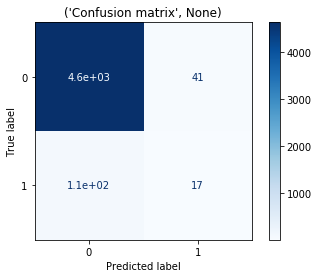

In [140]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None)]
for title in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()